# Session2: Linear Regression and Regularization


**Learning Objectives:**
- Understand the mathematical foundations of linear regression
- Learn how overfitting occurs with high-dimensional EEG data
- Master Ridge and Lasso regularization techniques
- Apply these methods to predict age from EEG band powers
- Interpret model coefficients for neuroscience insights

---

## 1. Setup and Imports

Let's begin by importing the necessary libraries for our analysis.

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# For reproducibility
np.random.seed(10)

## 2. Exploring EEG Data

For this session, we'll use simulated EEG data. The data contains band power features extracted from multiple EEG channels.

**EEG Frequency Bands:**
- **Delta (0.5-4 Hz):** Deep sleep, unconscious processes
- **Theta (4-8 Hz):** Drowsiness, meditation, memory
- **Alpha (8-13 Hz):** Relaxed wakefulness, closed eyes
- **Beta (13-30 Hz):** Active thinking, concentration
- **Gamma (30-100 Hz):** Higher cognitive functions, perception

In [72]:
# Simulating EEG dataset structure

def create_synthetic_eeg_data(n_subjects=150, n_channels=62, add_noise=True):
    """
    Create synthetic EEG band power data that mimics real EEG datasets.
    Features: band powers (delta, theta, alpha, beta, gamma) for each channel.
    Target: Age (ranging from 20 to 80 years)
    """
    bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    n_features = n_channels * len(bands)  # 62 channels × 5 bands = 310 features

    # Generate ages between 20 and 80
    ages = np.random.uniform(20, 80, n_subjects)

    # Create feature matrix
    X = np.zeros((n_subjects, n_features))

    # Simulate realistic relationships between age and EEG features
    for i in range(n_subjects):
        age_normalized = (ages[i] - 50) / 30  # Normalize age

        for channel in range(n_channels):
            # Delta power increases with age
            X[i, channel*5 + 0] = 10 + 0.3*age_normalized + np.random.randn()*2
            # Theta power slight decrease with age
            X[i, channel*5 + 1] = 8 - 0.15*age_normalized + np.random.randn()*1.5
            # Alpha power decreases with age (most informative)
            X[i, channel*5 + 2] = 12 - 0.4*age_normalized + np.random.randn()*2
            # Beta power relatively stable
            X[i, channel*5 + 3] = 6 + 0.1*age_normalized + np.random.randn()*1.5
            # Gamma power slight increase with age
            X[i, channel*5 + 4] = 4 + 0.2*age_normalized + np.random.randn()*1

    # Add noise features (irrelevant features)
    if add_noise:
        noise_features = np.random.randn(n_subjects, 50)
        X = np.hstack([X, noise_features])
        n_features += 50

    # Create column names
    feature_names = []
    for ch in range(n_channels):
        for band in bands:
            feature_names.append(f'Ch{ch+1}_{band}')
    if add_noise:
        for i in range(50):
            feature_names.append(f'noise_{i+1}')

    # Create DataFrame
    df = pd.DataFrame(X, columns=feature_names)
    df['age'] = ages
    df['subject_id'] = [f'sub-{i+1:03d}' for i in range(n_subjects)]

    return df

# Generate synthetic data
df = create_synthetic_eeg_data(n_subjects=150, n_channels=62, add_noise=True)

print(f"Dataset shape: {df.shape}")
print(f"\nNumber of subjects: {len(df)}")
print(f"Number of features: {df.shape[1] - 2}")  # Excluding 'age' and 'subject_id'
print(f"\nAge statistics:")
print(df['age'].describe())

# Display first few rows
print("\nFirst few rows:")
df.head()

Dataset shape: (150, 362)

Number of subjects: 150
Number of features: 360

Age statistics:
count    150.000000
mean      48.734563
std       16.638211
min       20.236896
25%       35.245071
50%       50.320978
75%       62.306593
max       79.257528
Name: age, dtype: float64

First few rows:


,Ch1_delta,Ch1_theta,Ch1_alpha,Ch1_beta,Ch1_gamma,Ch2_delta,Ch2_theta,Ch2_alpha,Ch2_beta,Ch2_gamma,...,noise_43,noise_44,noise_45,noise_46,noise_47,noise_48,noise_49,noise_50,age,subject_id
0,7.711120,7.585914,14.462796,6.098229,6.093914,13.057124,7.487160,9.064322,5.982202,3.627741,...,-1.976587,-1.104722,0.483180,0.241357,0.747141,0.065287,0.574412,0.842921,66.279239,sub-001
1,8.605814,6.484590,11.949129,4.591017,3.819082,7.899958,6.020145,12.572815,6.194851,4.351536,...,-1.069525,0.668051,0.318019,-1.857326,1.167112,-0.817704,-1.520480,-1.314439,21.245117,sub-002
2,14.384130,7.880068,10.389538,5.376071,3.948583,8.099341,8.880873,11.658654,3.428248,3.179658,...,1.056354,-0.577413,-0.853542,0.844544,-1.130631,0.943221,-1.540870,1.998004,58.018894,sub-003
3,9.554222,8.447577,13.437531,6.350512,3.733982,9.040954,8.647916,15.069962,7.102853,3.456255,...,1.475820,-1.027864,0.192255,-0.731226,1.491167,-0.139480,-1.603186,-1.101717,64.928233,sub-004
4,10.538811,7.764847,10.546266,7.908788,4.925510,9.902989,6.971037,13.159111,5.301762,3.827985,...,-0.449036,0.462290,-0.078004,-1.132489,-0.021831,0.335364,0.299269,-0.812392,49.910421,sub-005


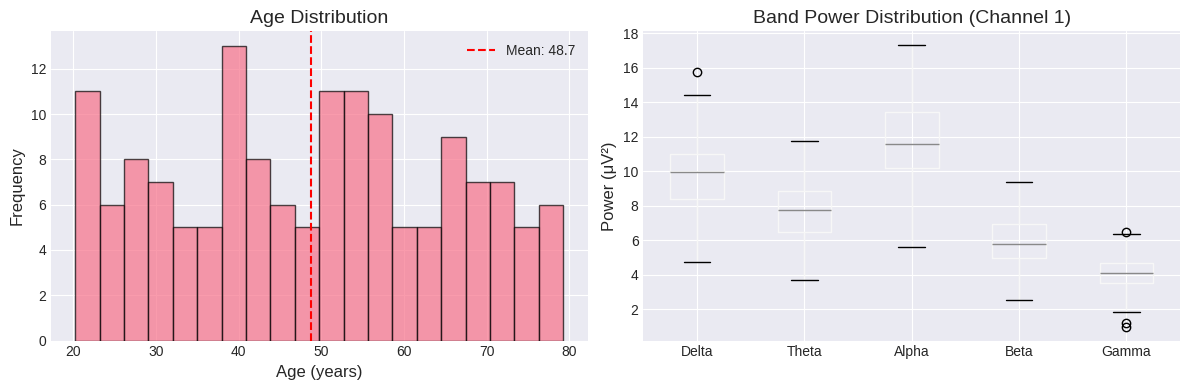

In [73]:
# Visualize age distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['age'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Age (years)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Age Distribution', fontsize=14)
axes[0].axvline(df['age'].mean(), color='red', linestyle='--', label=f'Mean: {df["age"].mean():.1f}')
axes[0].legend()

# Visualize sample of band powers
sample_features = ['Ch1_delta', 'Ch1_theta', 'Ch1_alpha', 'Ch1_beta', 'Ch1_gamma']
df[sample_features].boxplot(ax=axes[1])
axes[1].set_ylabel('Power (μV²)', fontsize=12)
axes[1].set_title('Band Power Distribution (Channel 1)', fontsize=14)
axes[1].set_xticklabels(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])

plt.tight_layout()
plt.show()

## 3. Linear Regression: Mathematical Foundation

Linear regression models the relationship between features (X) and a target variable (y) using a linear equation.

### The Model:
$$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_p x_p = \beta_0 + \mathbf{X}\boldsymbol{\beta}$$

Where:
- $\hat{y}$ is the predicted value
- $\beta_0$ is the intercept (bias term)
- $\beta_1, ..., \beta_p$ are the coefficients (weights)
- $x_1, ..., x_p$ are the features

### The Objective: Minimize Mean Squared Error (MSE)
$$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2 = \frac{1}{n}\sum_{i=1}^{n}(y_i - \mathbf{X}_i\boldsymbol{\beta})^2$$

This is also called the **loss function** or **cost function**.

### Analytical Solution (Normal Equation):
We can find the optimal coefficients by taking the derivative of MSE with respect to $\boldsymbol{\beta}$ and setting it to zero:

$$\boldsymbol{\beta}^* = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

This gives us the **ordinary least squares (OLS)** solution.

**Sensitive to multicollinearity:** When features are highly correlated, $(\mathbf{X}^T\mathbf{X})$ becomes nearly singular

## 4. Preparing Data for Modeling

Before fitting any model, we need to:
1. Split data into features (X) and target (y)
2. Create train/test split
3. **Standardize features** (critical for regularization!)

In [74]:
# Separate features and target
feature_cols = [col for col in df.columns if col not in ['age', 'subject_id']]
X = df[feature_cols].values
y = df['age'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nWe have {X.shape[1]} features to predict age!")

Feature matrix shape: (150, 360)
Target vector shape: (150,)

We have 360 features to predict age!


In [75]:
# train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=110)

### Why Standardization Matters

Standardization transforms features to have mean=0 and standard deviation=1:

$$x_{\text{scaled}} = \frac{x - \mu}{\sigma}$$

**Why is this crucial?**
1. **Features are on different scales:** Delta power might be ~10 μV², while gamma might be ~4 μV²
2. **Regularization penalizes all coefficients equally:** Without standardization, features with larger scales would be penalized less


⚠️ **Critical:** Always fit the scaler on training data only, then transform both train and test!

In [76]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data
X_test_scaled = scaler.transform(X_test)        # Transform test data

# Verify standardization
print("After standardization:")
print(f"Training data mean: {X_train_scaled.mean():.6f}")
print(f"Training data std: {X_train_scaled.std():.6f}")
print(f"\nTest data mean: {X_test_scaled.mean():.6f}")
print(f"Test data std: {X_test_scaled.std():.6f}")

After standardization:
Training data mean: 0.000000
Training data std: 1.000000

Test data mean: 0.001936
Test data std: 1.018768


### 5. Linear Regression on EEG Data

Let's fit our first model to predict age from EEG band powers.

In [77]:
# Fit linear regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("=" * 50)
print("LINEAR REGRESSION RESULTS")
print("=" * 50)
print(f"\nTraining Set:")
print(f"  MSE: {train_mse:.2f} years²")
print(f"  RMSE: {np.sqrt(train_mse):.2f} years")
print(f"  R²: {train_r2:.4f}")
print(f"\nTest Set:")
print(f"  MSE: {test_mse:.2f} years²")
print(f"  RMSE: {np.sqrt(test_mse):.2f} years")
print(f"  R²: {test_r2:.4f}")
print("\n" + "=" * 50)

LINEAR REGRESSION RESULTS

Training Set:
  MSE: 0.00 years²
  RMSE: 0.00 years
  R²: 1.0000

Test Set:
  MSE: 192.72 years²
  RMSE: 13.88 years
  R²: 0.0654



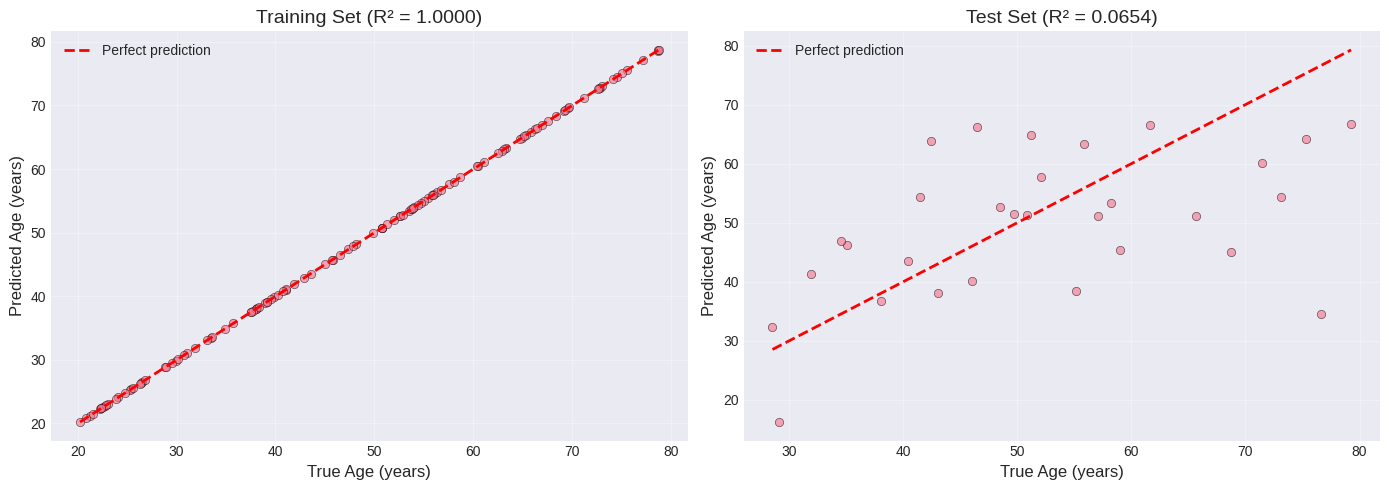

In [78]:
# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
             'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('True Age (years)', fontsize=12)
axes[0].set_ylabel('Predicted Age (years)', fontsize=12)
axes[0].set_title(f'Training Set (R² = {train_r2:.4f})', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect prediction')
axes[1].set_xlabel('True Age (years)', fontsize=12)
axes[1].set_ylabel('Predicted Age (years)', fontsize=12)
axes[1].set_title(f'Test Set (R² = {test_r2:.4f})', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Interpreting the Results

**R² (Coefficient of Determination):**
$$R^2 = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$$

- R² = 1: Perfect predictions
- R² = 0: Model performs as well as predicting the mean
- R² < 0: Model is worse than predicting the mean

**What do we observe?**
Notice that training R² might be very high, but test R² could be lower. This is our first hint of **overfitting**!

### 6. The Overfitting Problem

With EEG data, we often have:
- **High dimensionality:** 310+ features (62 channels × 5 bands + noise)
- **Limited samples:** Only 150 subjects
- **Multicollinearity:** Brain regions are correlated

This creates the **curse of dimensionality**:
$$\text{When } p \text{ (features) } >> n \text{ (samples)}$$

The model can fit the training data perfectly by exploiting noise and correlations, but fails to generalize.

### Demonstration: Effect of Number of Features

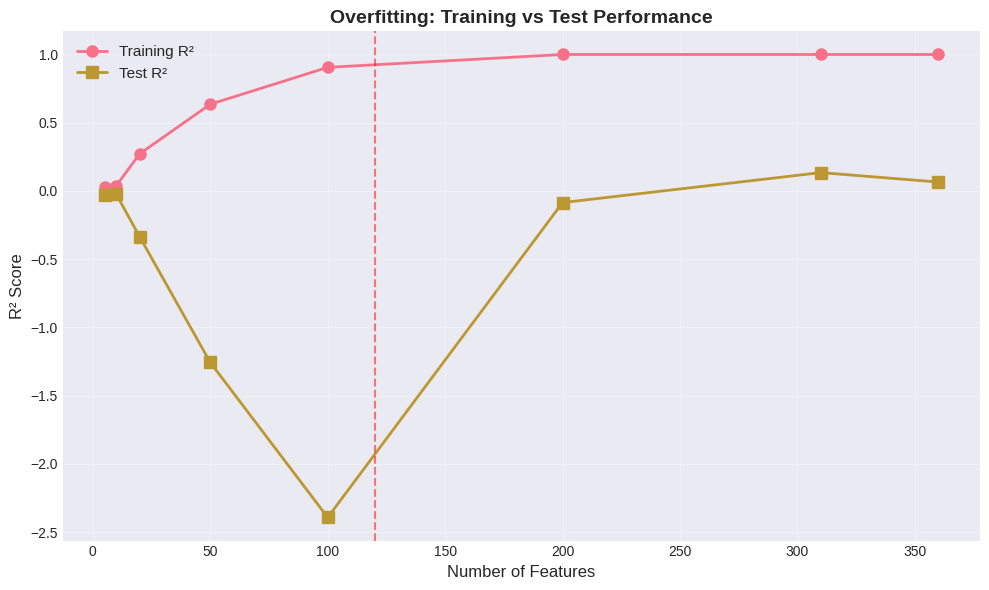


⚠️  OVERFITTING ALERT:
As we add more features, training R² keeps improving,
but test R² may decrease - the model memorizes noise!


In [79]:
# Let's see how performance changes as we add more features
n_features_list = [5, 10, 20, 50, 100, 200, 310, 360]
train_r2_list = []
test_r2_list = []

for n_feat in n_features_list:
    if n_feat <= X_train_scaled.shape[1]:
        # Use only first n_feat features
        lr = LinearRegression()
        lr.fit(X_train_scaled[:, :n_feat], y_train)

        train_pred = lr.predict(X_train_scaled[:, :n_feat])
        test_pred = lr.predict(X_test_scaled[:, :n_feat])

        train_r2_list.append(r2_score(y_train, train_pred))
        test_r2_list.append(r2_score(y_test, test_pred))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(n_features_list[:len(train_r2_list)], train_r2_list, 'o-', linewidth=2,
         markersize=8, label='Training R²')
plt.plot(n_features_list[:len(test_r2_list)], test_r2_list, 's-', linewidth=2,
         markersize=8, label='Test R²')
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Overfitting: Training vs Test Performance', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axvline(x=X_train.shape[0], color='red', linestyle='--', alpha=0.5,
            label=f'n_samples = {X_train.shape[0]}')
plt.tight_layout()
plt.show()

print("\n⚠️  OVERFITTING ALERT:")
print(f"As we add more features, training R² keeps improving,")
print(f"but test R² may decrease - the model memorizes noise!")

## 7. Ridge Regression (L2 Regularization)

Ridge regression adds a penalty term to the loss function to prevent overfitting.

### Mathematical Formulation:

**Objective Function:**
$$\min_{\boldsymbol{\beta}} \left\{ \frac{1}{n}\sum_{i=1}^{n}(y_i - \mathbf{X}_i\boldsymbol{\beta})^2 + \lambda\sum_{j=1}^{p}\beta_j^2 \right\}$$

Or more compactly:
$$\min_{\boldsymbol{\beta}} \{ \text{MSE} + \lambda||\boldsymbol{\beta}||_2^2 \}$$

Where:
- First term: Data fitting (same as ordinary linear regression)
- Second term: **L2 penalty** (regularization term)
- $\lambda$ (lambda): **Regularization strength** (hyperparameter)

### Analytical Solution:
$$\boldsymbol{\beta}^*_{\text{ridge}} = (\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$$

Notice: Adding $\lambda\mathbf{I}$ ensures the matrix is always invertible!

### Key Properties:
1. **Shrinks coefficients:** Pulls them toward zero but never exactly zero
2. **Handles multicollinearity:** Stabilizes coefficient estimates
3. **All features retained:** No automatic feature selection


In [80]:
# Fit Ridge regression with different lambda values
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]  # Note: sklearn uses 'alpha' for lambda
ridge_results = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)

    train_pred = ridge.predict(X_train_scaled)
    test_pred = ridge.predict(X_test_scaled)

    ridge_results.append({
        'lambda': alpha,
        'train_r2': r2_score(y_train, train_pred),
        'test_r2': r2_score(y_test, test_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
        'n_nonzero_coefs': np.sum(np.abs(ridge.coef_) > 1e-5)
    })

ridge_df = pd.DataFrame(ridge_results)
print("\nRidge Regression Results for Different Lambda Values:")
print(ridge_df.to_string(index=False))


Ridge Regression Results for Different Lambda Values:
  lambda  train_r2  test_r2  train_rmse  test_rmse  n_nonzero_coefs
   0.001  1.000000 0.065372    0.000054  13.882172              360
   0.010  1.000000 0.065411    0.000540  13.881883              360
   0.100  1.000000 0.065800    0.005399  13.878989              360
   1.000  0.999990 0.069653    0.053669  13.850341              360
  10.000  0.999109 0.104223    0.507039  13.590578              360
 100.000  0.958772 0.259170    3.448257  12.359397              360
1000.000  0.589221 0.211666   10.884418  12.749496              360


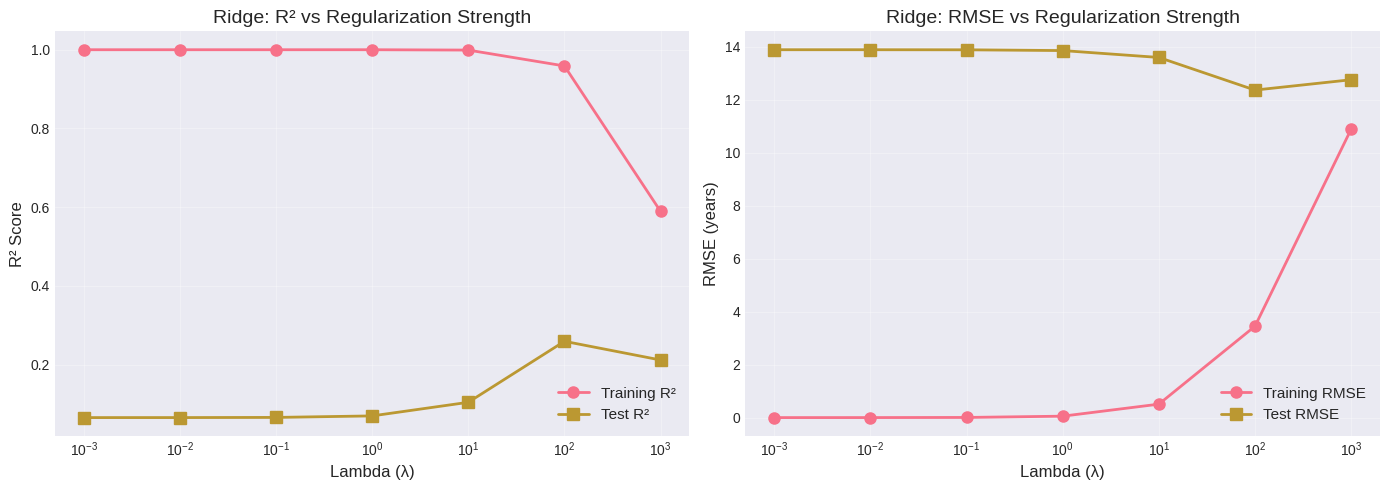


🎯 Optimal Lambda: 100.0
   Test R²: 0.2592
   Test RMSE: 12.36 years


In [81]:
# Visualize Ridge performance vs lambda
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² scores
axes[0].semilogx(ridge_df['lambda'], ridge_df['train_r2'], 'o-', linewidth=2,
                 markersize=8, label='Training R²')
axes[0].semilogx(ridge_df['lambda'], ridge_df['test_r2'], 's-', linewidth=2,
                 markersize=8, label='Test R²')
axes[0].set_xlabel('Lambda (λ)', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Ridge: R² vs Regularization Strength', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# RMSE
axes[1].semilogx(ridge_df['lambda'], ridge_df['train_rmse'], 'o-', linewidth=2,
                 markersize=8, label='Training RMSE')
axes[1].semilogx(ridge_df['lambda'], ridge_df['test_rmse'], 's-', linewidth=2,
                 markersize=8, label='Test RMSE')
axes[1].set_xlabel('Lambda (λ)', fontsize=12)
axes[1].set_ylabel('RMSE (years)', fontsize=12)
axes[1].set_title('Ridge: RMSE vs Regularization Strength', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal lambda
optimal_idx = ridge_df['test_r2'].idxmax()
optimal_lambda = ridge_df.loc[optimal_idx, 'lambda']
print(f"\n🎯 Optimal Lambda: {optimal_lambda}")
print(f"   Test R²: {ridge_df.loc[optimal_idx, 'test_r2']:.4f}")
print(f"   Test RMSE: {ridge_df.loc[optimal_idx, 'test_rmse']:.2f} years")

## 8. Lasso Regression (L1 Regularization)

Lasso (Least Absolute Shrinkage and Selection Operator) uses L1 penalty instead of L2.

### Mathematical Formulation:

**Objective Function:**
$$\min_{\boldsymbol{\beta}} \left\{ \frac{1}{n}\sum_{i=1}^{n}(y_i - \mathbf{X}_i\boldsymbol{\beta})^2 + \lambda\sum_{j=1}^{p}|\beta_j| \right\}$$

Or:
$$\min_{\boldsymbol{\beta}} \{ \text{MSE} + \lambda||\boldsymbol{\beta}||_1 \}$$

### Key Difference from Ridge:
- Ridge: $||\boldsymbol{\beta}||_2^2 = \sum \beta_j^2$ (squared terms)
- Lasso: $||\boldsymbol{\beta}||_1 = \sum |\beta_j|$ (absolute values)


### Key Properties:
1. **Automatic feature selection:** Sets many coefficients exactly to zero
2. **Sparse solutions:** Only keeps important features
3. **Instability:** Selected features can change with small data changes

In [82]:
# Fit Lasso regression with different lambda values
alphas = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]
lasso_results = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)

    train_pred = lasso.predict(X_train_scaled)
    test_pred = lasso.predict(X_test_scaled)

    lasso_results.append({
        'lambda': alpha,
        'train_r2': r2_score(y_train, train_pred),
        'test_r2': r2_score(y_test, test_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
        'n_nonzero_coefs': np.sum(np.abs(lasso.coef_) > 1e-5)
    })

lasso_df = pd.DataFrame(lasso_results)
print("\nLasso Regression Results for Different Lambda Values:")
print(lasso_df.to_string(index=False))
print("\n✨ Notice: Lasso drives many coefficients to exactly ZERO!")


Lasso Regression Results for Different Lambda Values:
 lambda  train_r2   test_r2  train_rmse  test_rmse  n_nonzero_coefs
  0.001  1.000000 -0.479185    0.010072  17.464219              156
  0.010  0.999964 -0.663752    0.101686  18.521761              127
  0.100  0.996835 -0.527246    0.955378  17.745673              114
  0.500  0.944498  0.072393    4.000893  13.829931               83
  1.000  0.853223  0.187147    6.506237  12.946249               59
  5.000  0.061932 -0.032253   16.448202  14.589186                3
 10.000  0.000000 -0.091594   16.982489  15.002672                0

✨ Notice: Lasso drives many coefficients to exactly ZERO!


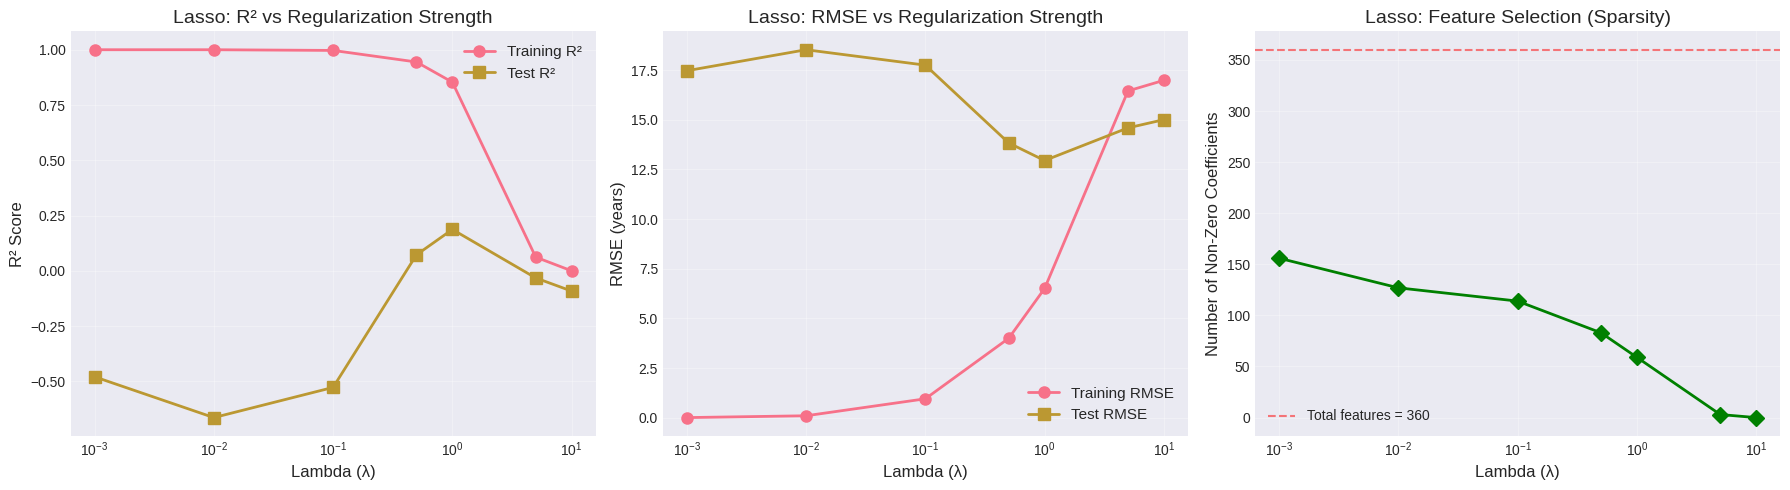


🎯 Optimal Lambda: 1.0
   Test R²: 0.1871
   Test RMSE: 12.95 years
   Features selected: 59/360


In [83]:
# Visualize Lasso performance and sparsity
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² scores
axes[0].semilogx(lasso_df['lambda'], lasso_df['train_r2'], 'o-', linewidth=2,
                 markersize=8, label='Training R²')
axes[0].semilogx(lasso_df['lambda'], lasso_df['test_r2'], 's-', linewidth=2,
                 markersize=8, label='Test R²')
axes[0].set_xlabel('Lambda (λ)', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Lasso: R² vs Regularization Strength', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# RMSE
axes[1].semilogx(lasso_df['lambda'], lasso_df['train_rmse'], 'o-', linewidth=2,
                 markersize=8, label='Training RMSE')
axes[1].semilogx(lasso_df['lambda'], lasso_df['test_rmse'], 's-', linewidth=2,
                 markersize=8, label='Test RMSE')
axes[1].set_xlabel('Lambda (λ)', fontsize=12)
axes[1].set_ylabel('RMSE (years)', fontsize=12)
axes[1].set_title('Lasso: RMSE vs Regularization Strength', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Sparsity
axes[2].semilogx(lasso_df['lambda'], lasso_df['n_nonzero_coefs'], 'D-', linewidth=2,
                 markersize=8, color='green')
axes[2].set_xlabel('Lambda (λ)', fontsize=12)
axes[2].set_ylabel('Number of Non-Zero Coefficients', fontsize=12)
axes[2].set_title('Lasso: Feature Selection (Sparsity)', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=X_train.shape[1], color='red', linestyle='--', alpha=0.5,
                label=f'Total features = {X_train.shape[1]}')
axes[2].legend(fontsize=10)

plt.tight_layout()
plt.show()

# Find optimal lambda
optimal_idx = lasso_df['test_r2'].idxmax()
optimal_lambda = lasso_df.loc[optimal_idx, 'lambda']
print(f"\n🎯 Optimal Lambda: {optimal_lambda}")
print(f"   Test R²: {lasso_df.loc[optimal_idx, 'test_r2']:.4f}")
print(f"   Test RMSE: {lasso_df.loc[optimal_idx, 'test_rmse']:.2f} years")
print(f"   Features selected: {lasso_df.loc[optimal_idx, 'n_nonzero_coefs']}/{X_train.shape[1]}")

## 9. Ridge vs Lasso: Regularization Paths

Let's visualize how coefficients change as we increase regularization strength. This is called the **regularization path**.

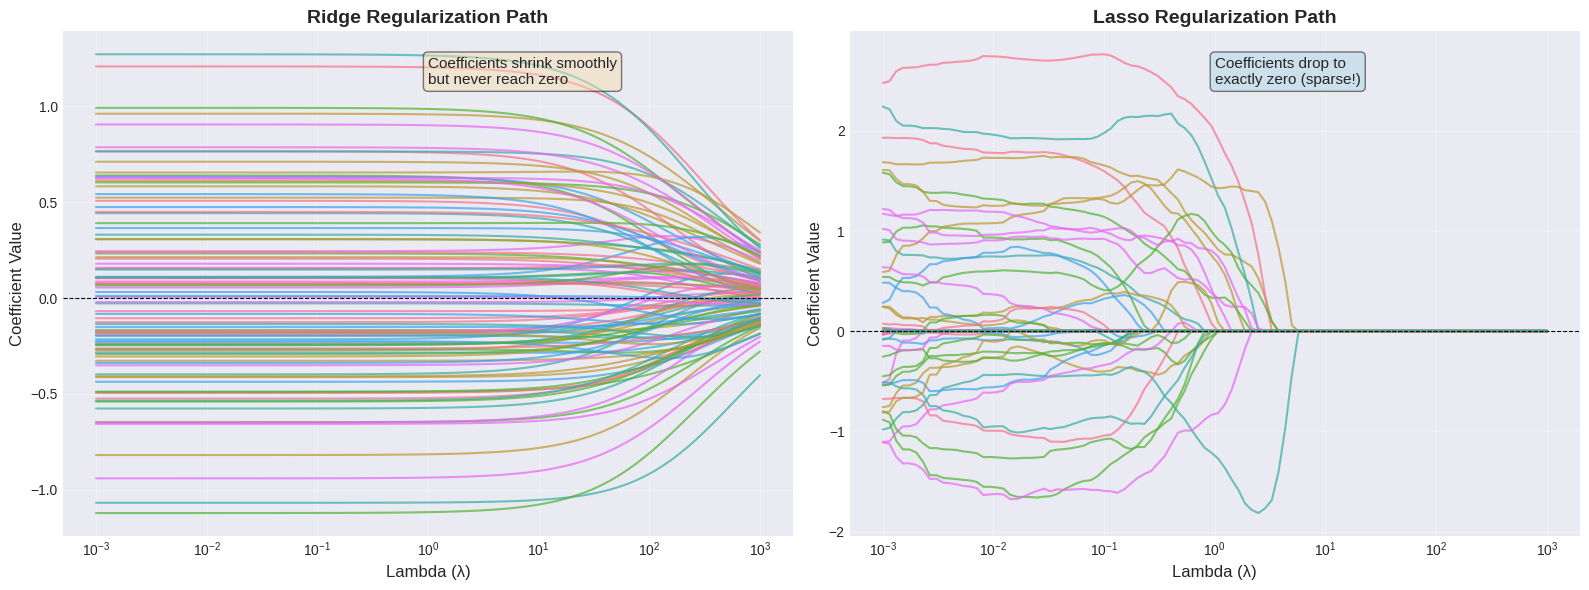


📊 Key Observations:
   • Ridge: All coefficients shrink smoothly toward zero
   • Lasso: Coefficients hit zero at different λ values


In [84]:
# Compute regularization paths
alphas_path = np.logspace(-3, 3, 100)
ridge_coefs = []
lasso_coefs = []

for alpha in alphas_path:
    # Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge.coef_)

    # Lasso
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

# Plot regularization paths for first 20 features (for clarity)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Ridge path
for i in range(100):
    axes[0].semilogx(alphas_path, ridge_coefs[:, i], linewidth=1.5, alpha=0.7)
axes[0].set_xlabel('Lambda (λ)', fontsize=12)
axes[0].set_ylabel('Coefficient Value', fontsize=12)
axes[0].set_title('Ridge Regularization Path', fontsize=14, fontweight='bold')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[0].grid(True, alpha=0.3)
axes[0].text(0.5, 0.95, 'Coefficients shrink smoothly\nbut never reach zero',
             transform=axes[0].transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Lasso path
for i in range(100):
    axes[1].semilogx(alphas_path, lasso_coefs[:, i], linewidth=1.5, alpha=0.7)
axes[1].set_xlabel('Lambda (λ)', fontsize=12)
axes[1].set_ylabel('Coefficient Value', fontsize=12)
axes[1].set_title('Lasso Regularization Path', fontsize=14, fontweight='bold')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[1].grid(True, alpha=0.3)
axes[1].text(0.5, 0.95, 'Coefficients drop to\nexactly zero (sparse!)',
             transform=axes[1].transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("   • Ridge: All coefficients shrink smoothly toward zero")
print("   • Lasso: Coefficients hit zero at different λ values")

## 10. Model Comparison

Let's compare all three approaches side by side.

In [85]:
# Train all models with their optimal hyperparameters
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (λ=100)': Ridge(alpha=100),
    'Lasso (λ=1)': Lasso(alpha=1, max_iter=10000)
}

comparison_results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)

    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)

    comparison_results.append({
        'Model': name,
        'Train R²': r2_score(y_train, train_pred),
        'Test R²': r2_score(y_test, test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, test_pred)),
        'Non-zero coefs': np.sum(np.abs(model.coef_) > 1e-5) if hasattr(model, 'coef_') else 0
    })

comparison_df = pd.DataFrame(comparison_results)
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


COMPREHENSIVE MODEL COMPARISON
            Model  Train R²  Test R²   Train RMSE  Test RMSE  Non-zero coefs
Linear Regression  1.000000 0.065367 2.990758e-14  13.882205             360
    Ridge (λ=100)  0.958772 0.259170 3.448257e+00  12.359397             360
      Lasso (λ=1)  0.853223 0.187147 6.506237e+00  12.946249              59


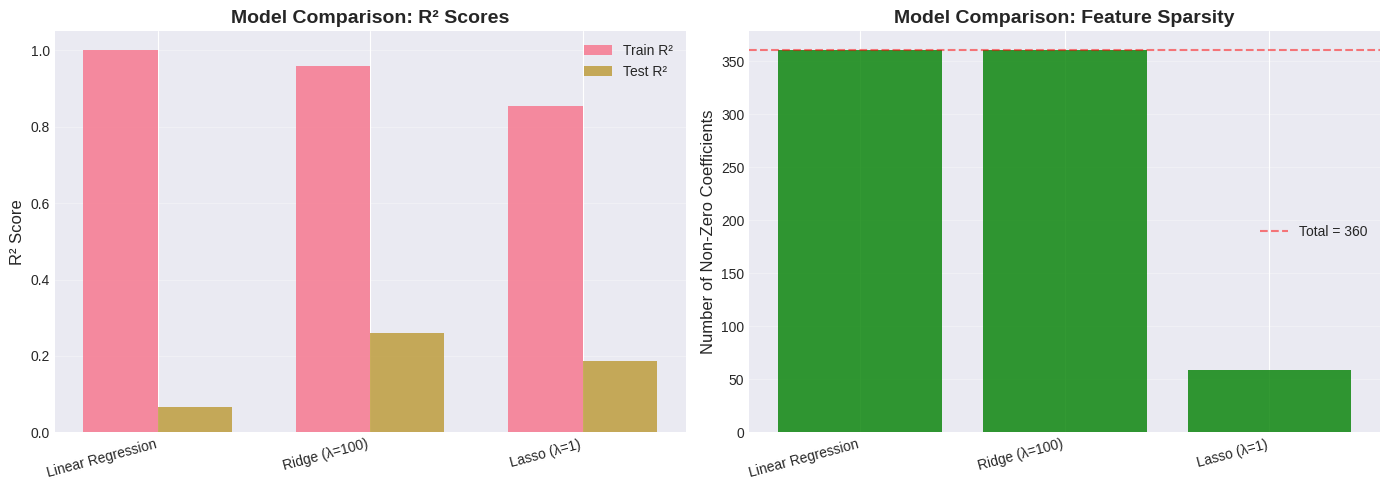

In [86]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
x = np.arange(len(comparison_df))
width = 0.35
axes[0].bar(x - width/2, comparison_df['Train R²'], width, label='Train R²', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Test R²'], width, label='Test R²', alpha=0.8)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Model Comparison: R² Scores', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Feature sparsity
axes[1].bar(comparison_df['Model'], comparison_df['Non-zero coefs'], alpha=0.8, color='green')
axes[1].set_ylabel('Number of Non-Zero Coefficients', fontsize=12)
axes[1].set_title('Model Comparison: Feature Sparsity', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[1].axhline(y=X_train.shape[1], color='red', linestyle='--', alpha=0.5,
                label=f'Total = {X_train.shape[1]}')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



 ## 🎯 Project: Comprehensive EEG Regression Analysis

 Using the DEAP dataset, complete the following analysis:
 https://drive.google.com/drive/folders/101UUc-5BtBMUQ8zb71YCsjyRXwlt6v0S?usp=sharing

📋 ASSIGNMENT OBJECTIVES:
Your task is to build and compare regression models for emotion prediction
from EEG features, demonstrating mastery of regularization techniques.


🎯 PART A: Data Preparation
1. Load the EEG dataset
2. Extract power spectral features
3. Create target variables:
   - Emotional measure (e.g. valence)
4. Split data
5. Properly standardize features (document your approach)

🔬 PART B: Model Development
1. Implement OLS baseline
2. Ridge Regression:
   - Test at least 10 different λ values
   - Plot coefficient paths
   - Select optimal λ
3. Lasso Regression:
   - Test at least 10 different λ values
   - Document feature selection at each λ
   - Analyze which channels/bands are selected

📊 PART C: Analysis & Interpretation
1. Create a comprehensive comparison table showing:
   - Training and test performance (R², MSE, MAE)
   - Number of features used
   - Computational time

2. Visualization requirements (minimum 4 plots):
   - Regularization paths for both Ridge and Lasso
   - Actual vs Predicted scatter plots for best models
   - Heatmap of selected features (channels × frequency bands)
   - Performance vs λ curves for both methods

3. Answer these questions:
   a) Which method works best? Why?
   b) Which EEG features are most predictive for each target?
   c) How does the optimal λ differ between targets?
   d) What happens if you DON'T standardize features? (show empirically)


لینک نوتبوک تمرین:
https://colab.research.google.com/drive/10BcjlxMbPvT4D40QEgv_Av74P1hwoqK6?usp=sharing